<table style="width:100%"><tr>
<td> 
    
Technische Universität Berlin\
Electrical Engineering and Computer Science\
Internet of Things for Smart Buildings\
Prof. Dr. Sergio Lucia, Felix Fiedler, Benjamin Karg </td>
<td>  <img src="logo_tu.png" style="width: 20%;" align="right"/> </td>
</tr>
</table>

***
**MPC 20 - Exercise 03**
***

# Please click here!

# ODE discretization: Orthogonal collocation on finite elements

In this exercise we will continue working with the Python library [CasADi](https://web.casadi.org/docs/)
and use it to implement our own MPC for **a nonlinear system expressed as an ordinary differential equation (ODE)**: 

$$
\dot x = f(x,u)
$$

Note that last week we dealt with the linear discrete-time formulation:

$$
x_{k+1} = Ax_k+Bu_k
$$

The main difficulty with the ODE is that we need numerical integration. The simplest approach in this regard is the well known Euler integration, where:

$$
x_{k+1} = x_k + \Delta t f(x_k,u_k).
$$

In most cases, however, the integration error with this approach will prevent a successfull MPC implementation.
Instead we apply **orthogonal collocation on finite elements**, which we formally introduce and implement in the following.

But first we import the required Python packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from casadi import *

We also change some Matplotlib parameters to increase the font size. Here is some [information](https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html) on how this works.

In [2]:
mpl.rcParams['font.size'] = 16

## Example system
For this exercise we consider a non-linear "leaf spring" system, which can be modelled as:

$$
m \ddot{x} = -k_1 x - k_2 x^{3}
$$

Such a spring is used on car suspensions – the more it deflects, the stiffer it gets.

We write this second order ODE as a coupled system of first oder ODE's as follows:

\begin{align}
\dot x_1 &= x_2\\
\dot x_2 &= -k_1 x_1 - k_2 x_1^{3}
\end{align}

We then use CasADi to define the system.

In [3]:
nx = 2
nu = 1

x = SX.sym('x', nx)
u = SX.sym('u', nu)
k = np.array([-1, 0.5])

xdot = vertcat(
    x[1],
    -k[0]*x[0]-k[1]*x[0]**3+u
)

# Create the CasADi function
system = Function("sys",[x,u],[xdot])


# Timestep
dt = 0.2

In contrast to previous week, we now have a continuous-time ordinary differential equation. To obtain the time-series of the states we thus need to use numerical integration. 

We use the CasADi interface of the state-of-the-art IDAS integrator ([Sundials](https://computing.llnl.gov/projects/sundials/idas)).


**Note that we cannot use this Integrator directly for MPC** (unless you want to implement single-shooting or multiple-shooting). 
We use the Integrator **only for simulating the system**.

In [4]:
ode = {'x': x, 'ode': xdot, 'p': u}
opts = {'tf': dt}
ode_solver = integrator('F', 'idas', ode, opts)

The obtained ``ode_solver`` is a function that can be called with the initial state ``x0`` and the integration parameters ``p``. We use the parameters to pass the current input ``u``.

Let's see how the uncontrolled system behaves. 

## Task XX: Simulate the system

In [5]:
# Define the total steps to simulate
N_sim = 100
# Define the initial condition
x_0 = np.array([-2,1]).reshape(nx,1)
# Define the input (for the moment consider u = 0)
u_k = np.array([[0]])

res_x = [x_0]

In [6]:
for i in range(N_sim):
    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']
    res_x.append(x_next)
    x_0 = x_next

# Make an array from the list of arrays:
res_x = np.concatenate(res_x,axis=1)

Text(0.5, 0, 'time')

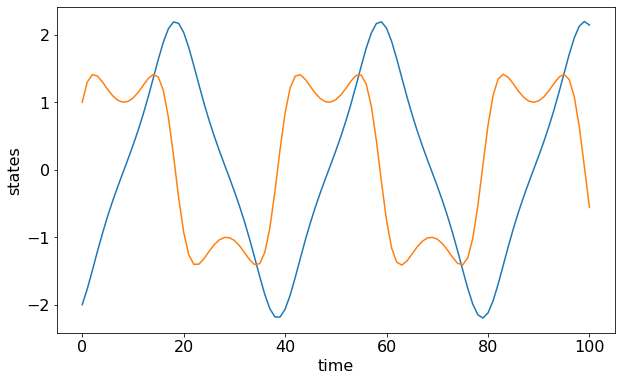

In [7]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the states
lines = ax.plot(res_x.T)


# Set labels
ax.set_ylabel('states')
ax.set_xlabel('time')

# Lagrange Polynomials
Fundamental for orthogonal collocation is the idea that the solution of the ODE:

$$
\dot{x} = f(x), \quad x(0)=x_0,
$$

which is $x(t)$, can be approximated accurately with a polynomial of order $k+1$:

$$
x^K_i(t) = \alpha_0 + \alpha_1 t + \dots + \alpha_{K}  t^K
$$

This approximation should be valid on small time-intervals $t\in [t_i, t_{i+1}]$, which
are the **finite elements** mentioned in the title.

Within the interval, we have $j=0,\dots,K$ interpolation points $x_{i,j}$
to determine the **Lagrange interpolation polynomial**:

\begin{align}
&x^K_i(t) = \sum_{j=0}^K L_j(\tau) x_{i,j}\\
\text{where:}\quad
&L_j(\tau) = \prod_{
\begin{array}{c}k=0\\ k \neq j \end{array}
}^K \frac{(\tau-\tau_k)}{(\tau_j-\tau_k)}, \quad &\tau = \frac{t-t_i}{\Delta t_i}, \quad \Delta t_i=t_{i+1}-t_i.
\end{align}

We call $L_j(\tau)$ the Lagrangrian basis polynomial with the dimensionless time $\tau \in [0,1]$. Note that the basis polynomial $L_j(\tau)$ is constructed to be $L_j(\tau_j)=1$ and $L_j(\tau_i)=0$ for all other interpolation points $i\neq j$.

In the following **we will allways choose** $\tau_0=0,\ \tau_j<\tau_{j+1}\leq 1,\ j=0,\dots,K-1$.

## Task 01: Simple Interpolation
Before we use Lagrange polynomials to solve the ODE (with or without MPC), let's validate that they actually work as advertised ...

1. Implement the function ``L(tau_col, tau, j)`` which returns $L_j(\tau)$ for a given list of collocation points.

In [8]:
def L(tau_col, tau, j):
    l = 1
    for k in range(len(tau_col)):
        if k!=j:
            l *= (tau-tau_col[k])/(tau_col[j]-tau_col[k]) 
    return l

2. Implement ``LgrInter(tau_col, tau, xk``, which evaluates $x^K_i(t)$ for all $\tau$ and for the interpolation points ``xk``.

In [9]:
def LgrInter(tau_col, tau, xk):
    z = 0
    for j in range(K):
        z += L(tau_col, tau, j)*xk[j,:]
        
    return z

We call the function ``LgrInter`` which returns the evaluated Lagrange polynomial.

In [10]:
# collocation degree.
K = 3

# Fix the random seed (results are always the same)
np.random.seed(1234)

# Get some linearly spaced collocation points between 0 and 1.
tau_col = np.linspace(0,1, num=K)
# Get some xk values for the collocation points.
xk = np.random.randn(K,2)

# Get the evaluated interpolation polynomial.
tau = np.linspace(0,1,100).reshape(-1,1)
x_interpolation = LgrInter(tau_col, tau, xk)

We plot the results:

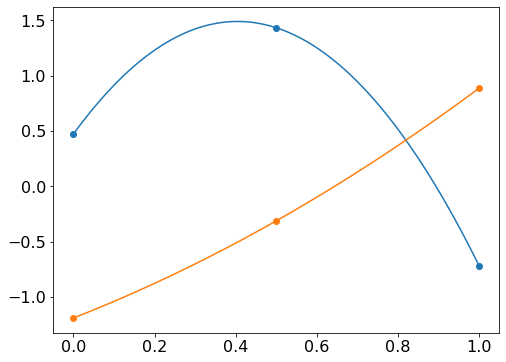

In [11]:
fig, ax= plt.subplots(figsize=(8,6))

ax.plot(tau, x_interpolation)
ax.set_prop_cycle(None)
ax.plot(tau_col, xk,'o')

And see that our Lagrange polynomials perfectly fit the supplied data points.

## Solving the ODE with orthogonal collocation

<img src="./figures/orthogonal_collocation.svg" style="width: 80%;" align="center"/>

So far we have seen how to approximate an ODE solution
with Lagrange polynomials **given a set of values from the solution**.
This may seem confusing because we are looking for these values in the first place.
However, it still helps us because we can now state conditions based on this polynomial representation
that **must hold for the desired solution**:

$$
\left.\frac{d x^K_i}{dt}\right|_{t_{i,k}} = f(x_{i,k}), \quad k=1,\dots,K.
$$


This means that the time derivatives from our polynomial approximation evaluated
**at the collocation points** must be equal to the original ODE at these same points.
**Note** that we excluded the collocation point $\tau_0=0$, which is treated seperately.

Because we assumed a polynomial structure of $x^K_i(t)$ the time derivative can be conveniently expressed as:

$$
\left.\frac{d x^K_i}{dt}\right|_{t_{i,k}} = \sum_{j=0}^K \frac{x_{i,j}}{\Delta t}
    \underbrace{\left.\frac{d L_j}{d \tau}\right|_{\tau_k}}_{a_{j,k}},
$$

for which we substituted $t$ with $\tau$ (dimensionless time between 0 and 1).
It is important to notice that **for fixed collocation points** the terms $a_{j,k}$
**are constants that can be pre-computed.**
The choice of these points is significant and will be discussed later in this notebook.

### Collocation constraints


The solution of the ODE, i.e. the values of $x_{i,j}$ are now obtained by solving
the set of equations:

$$
\sum_{j=0}^K a_{j,k} \frac{x_{i,j}}{\Delta t} = f(x_{i,k}), \quad k=1,\dots,K.
$$



### Collocation with orthogonal polynomials

Above we used Lagrange polynomials to interpolate on arbitrary **collocation** points. 
To solve an ODE, it shows that certain **collocation** points are better than others.

Favorable properties are obtained when choosing the collocation points as the roots of a $k$-th degree **Gauss-Jacoby** polynomial:

$$
\int_0^1 (1-\tau)^{\alpha} \tau^{\beta} P_i(\tau) P_{j}(\tau) = 0, \quad i=0,\dots, K-1,\ j=1,\dots, K
$$

which is a general class of **orthogonal polynomials**. Specific cases of this polynomial are obtained for $\alpha=0,\ \beta=0$ (**Legrende polynomial**) and for $\alpha=1,\ \beta=0$ (**Radau**) polynomial. 

We don't want to discuss here, why these collocation points are favorable or how to compute them. In practise we can just obtain the values from tables and fortunately they are also available from CasADi:

In [12]:
print(collocation_points(K,'radau'))
print(collocation_points(K,'legendre'))

[0.15505102572168222, 0.6449489742783179, 1.0]
[0.11270166537925824, 0.5, 0.8872983346207417]


Note that these collocation points do not include $\tau_0=0$. For a given collocation degree $K$, we append:

In [51]:
# collocation degree
K = 2 

# collocation points (excluding 0)
tau_col = collocation_points(K,'radau')

# collocation points (including 0)
tau_col = [0]+tau_col

print(tau_col)

[0, 0.33333333333333337, 1.0]


We now want to implement the collocation constraints:

$$
\sum_{j=0}^K a_{j,k} \frac{x_{i,j}}{\Delta t} = f(x_{i,k}), \quad k=1,\dots,K.
$$

For this we compute the coefficients 

$$a_{j,k} = \left.\frac{d L_j}{d \tau}\right|_{\tau_k},$$ 

which we store in the matrix $A$, where:

$$
A_{i,j} = a_{i,j}
$$

## Task XX:  Calculate orthogonal collocation coefficients
Calculate the orthogonal collocation coefficients $a_{j,k}$ and store them in a matrix $A$.
You can use CasADi and should introduce the symbolic variable $\tau$ and use your previously written function ``L(tau_col, tau, j)``. 

In [52]:
tau = SX.sym('tau')

A = np.zeros((K+1,K+1))

for j in range(K+1):
    dLj = gradient(L(tau_col, tau, j), tau)
    dLj_fcn = Function('dLj_fcn', [tau], [dLj])
    for k in range(K+1):
        A[j,k] = dLj_fcn(tau_col[k])
        

For $K=2$ and Radau collocation points you should obtain:
```python
A
>> array([[-4. , -2. ,  2. ],
          [ 4.5,  1.5, -4.5],
          [-0.5,  0.5,  2.5]])
```

With our choice of collocation points $\tau_0=0,\ \tau_j<\tau_{j+1}\leq 1,\ j=0,\dots,K-1$, we have included the initial state in the finite element **but not the final state**. Given the collocation points and their respective values, we thus want to evaluate the interpolation polynomial:

$$
x_i^f = x^K_i(t_{i+1}) = \sum_{j=0}^K L_j(\tau=1) x_{i,j}
$$

Again, **we don't know $x_{i,j}$ yet**, but we can determine $d_j = L_j(\tau=1),\ j=0,\dots, K$.
**Note that $d_j$ is a constant for fixed collocation points.**

We store the values of $d_j$ in the vector $D$.

## Task XX: Calculate continuity coefficients
Caculate the coeffcient $d_j$ and store them in the vector $D$. Use CasAdi, the symbolic variable $\tau$ and your function ``L(tau_col, tau, j)``.

In [54]:
D = np.zeros((K+1,1))

for j in range(K+1):
    Lj = L(tau_col, tau, j)
    Lj_fcn = Function('Lj', [tau], [Lj])
    D[j] = Lj_fcn(1)

For $K=2$ and Radau collocation points you should obtain:
```python
D
>> array([[ 0.],
          [-0.],
          [ 1.]])
```
This shouldn't be surprising, as the Radau colloction points include $\tau_{K}=1$.

# Integrating the ODE with orthogonal collocation

Before we implement MPC with orthogonal collocation we simply **apply it to solve the ODE**.

To use orthogonal collocation as an ODE solver we introduce the following optimization problem:

\begin{align}
&\min_{x_{i,0},\dots, x_{i,K}} \quad &0\\
&\text{s.t.} &\sum_{j=0}^K a_{j,k} x_{i,j} - \Delta t f(x_{i,k})=0, \quad k=1,\dots,K\\
& &x_{i,0} = x_{\text{init}}
\end{align}

We don't have an objective function but want to satisfy the collocation constraints.

## Task XX: Create an optimization problem to solve the collocation problem

In [58]:
X = SX.sym('X', nx, K+1)
x0 = SX.sym('x0', nx)
uk = SX.sym('uk', nu)

g = []

g0 = X[:,0]-x0
g.append(g0)

for k in range(1,K+1):
    gk = -dt*system(X[:,k], uk)
    for j in range(K+1):
        gk += A[j,k]*X[:,j]
        
    g.append(gk)
    
    
g = vertcat(*g)    

In [59]:
nlp = {'x':X.reshape((-1,1)), 'g':g, 'p':vertcat(x0, uk)}
S = nlpsol('S', 'ipopt', nlp)

## Task XX: Solve the ODE with orthogonal collocation
We define the initial state and control input as above when we first investigated the system response.

In [60]:
# Define the initial condition
x_0 = np.array([-2,1]).reshape(2,1)
# Define the input (for the moment consider u = 0)
u_k = np.array([[0]])

In a loop:
- call the previously created optimizer with the current initial state and control input. The upper and lower bound for ``g`` are zero (equality constraint).
- Extract the solution ``X``.
- Obtain $x_i^f$ (the state at $\tau = 1 $ with the previously created $d_j = L_j(\tau=1)\ j=0,\dots, K$.
- Store the new final state $x_i^f$.
- Update the initial state.


In [61]:
res_x_oc = [x_0]

for i in range(N_sim):
    res_k = S(lbg=0, ubg=0, p=vertcat(x_0, u_k))
    X_k = res_k['x'].full().reshape(K+1,nx)
    x_next = X_k.T@D
    res_x_oc.append(x_next)
    x_0 = x_next

# Make an array from the list of arrays:
res_x_oc = np.concatenate(res_x_oc,axis=1)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       18
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       18
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.13e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

   nlp_jac_g  |  10.00us (  2.00us)   5.00us (  1.00us)         5
       total  |   2.00ms (  2.00ms)   1.92ms (  1.92ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       18
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality c

We have prepared this plot to compare the orthogonal collocation result with the Sundials results from above.

Text(0.5, 0, 'time')

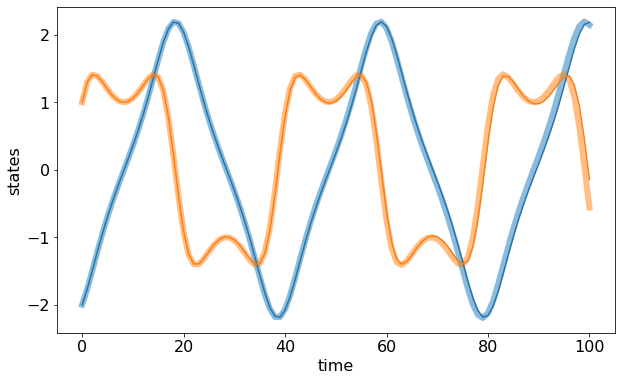

In [62]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the states
ax.plot(res_x.T, alpha=0.5, linewidth=6)
ax.set_prop_cycle(None)
ax.plot(res_x_oc.T)


# Set labels
ax.set_ylabel('states')
ax.set_xlabel('time')

Orthogonal collocation yields very good results but we can still see a minor **integration error**.

# MPC with orthogonal collocation

We can now very easily extend our previous MPC implementation (for the discrete-time case) to the non-linear continuous example. 

**What is different?**
- the optimization problem includes the collocation constraints.
- For each time-interval (finite element) we have a constant control input but $K+1$ instances of the states at the different collocation points.
- Bounds for the states can be set for all collocation points or just for the state at $\tau = 0$.
- the cost function can be evaluated for all collocation points or just for the state at $\tau = 0$.

Here, we decide to evaluate the cost function only at $\tau = 0$ and set upper and lower bounds for the states for all collocation points. 

With these differences in mind, we follow the scheme from last week and start by defining the cost function.

The objective of the MPC controller is to regulate the system. To achieve this goal we use a very common quadratic cost function, where for every time step $i$ of the horizon the following expression should be minimized:

$$l(x_{i,0},u_i) = x_{i,0}^T Q x_{i,0} + u_i^T R u_i $$

where Q and R are positive definite diagonal matrices. 
For the terminal cost we have a slightly altered expression:

$$ m(x_{N+1,0}) = x_{N+1,0}^T P x_{N+1,0}, $$ 

For simplicity we assume $P=Q$.

In [23]:
Q = 20
Q = Q*np.diag(np.ones(nx))
print(Q)

[[20.  0.]
 [ 0. 20.]]


In [24]:
R = 10
R = np.diag(R*np.ones(nu))
print(R)

[[10.]]


Another important parameter to choose is the prediction horizon. This determines "how far we look into the future". Note that an optimal solution does not guarante stability. **Feel free to test other values for the horizon**.

In [25]:
N = 20

In [26]:
# state cost
stage_cost = x.T@Q@x+ u.T@R@u
stage_cost_fcn = Function('stage_cost',[x,u],[stage_cost])

# terminal cost
terminal_cost = x.T@Q@x
terminal_cost_fcn = Function('terminal_cost',[x],[terminal_cost])

### Upper and lower bounds for stage variables:
These are suggested values that can be changed later.

In [27]:
# state constraints
lb_x = -4*np.ones((nx,1))
ub_x = 4*np.ones((nx,1))
# input constraints
lb_u = -0.4*np.ones((nu,1))
ub_u = 0.4*np.ones((nu,1))

## Define optimization variables

The optimization variables are now taking a rather complicated form. We have $n_x$ states for $N$ finite elements and $K+1$ collocation points in each interval. Since CasADi requires **a single vector** we must also concatenate the $N$ inputs with the $n_x \times N \times K+1$ states. 
To make our life easier, we will profit from another CasADi feature: **the structured symbolic variable**.  

First we must import the feature with:

In [28]:
from casadi.tools import *

We can then define:

In [29]:
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1, K+1]),
    entry('u', shape=nu, repeat=[N])
])

This "optimization variable x" **contains the states and inputs for all time-steps and all collocation points**.
Let's quickly investigate it:

In [30]:
print(opt_x)

symbolic SX with following structure:
Structure with total size 146.
Structure holding 2 entries.
  Order: ['x', 'u']
  x = repeated([21, 3]): 2x1
  u = repeated([20]): 1x1



We already get a lot of information. If we use:

In [31]:
vertcat(opt_x)

SX([x_0_0_0, x_0_0_1, x_0_1_0, x_0_1_1, x_0_2_0, x_0_2_1, x_1_0_0, x_1_0_1, x_1_1_0, x_1_1_1, x_1_2_0, x_1_2_1, x_2_0_0, x_2_0_1, x_2_1_0, x_2_1_1, x_2_2_0, x_2_2_1, x_3_0_0, x_3_0_1, x_3_1_0, x_3_1_1, x_3_2_0, x_3_2_1, x_4_0_0, x_4_0_1, x_4_1_0, x_4_1_1, x_4_2_0, x_4_2_1, x_5_0_0, x_5_0_1, x_5_1_0, x_5_1_1, x_5_2_0, x_5_2_1, x_6_0_0, x_6_0_1, x_6_1_0, x_6_1_1, x_6_2_0, x_6_2_1, x_7_0_0, x_7_0_1, x_7_1_0, x_7_1_1, x_7_2_0, x_7_2_1, x_8_0_0, x_8_0_1, x_8_1_0, x_8_1_1, x_8_2_0, x_8_2_1, x_9_0_0, x_9_0_1, x_9_1_0, x_9_1_1, x_9_2_0, x_9_2_1, x_10_0_0, x_10_0_1, x_10_1_0, x_10_1_1, x_10_2_0, x_10_2_1, x_11_0_0, x_11_0_1, x_11_1_0, x_11_1_1, x_11_2_0, x_11_2_1, x_12_0_0, x_12_0_1, x_12_1_0, x_12_1_1, x_12_2_0, x_12_2_1, x_13_0_0, x_13_0_1, x_13_1_0, x_13_1_1, x_13_2_0, x_13_2_1, x_14_0_0, x_14_0_1, x_14_1_0, x_14_1_1, x_14_2_0, x_14_2_1, x_15_0_0, x_15_0_1, x_15_1_0, x_15_1_1, x_15_2_0, x_15_2_1, x_16_0_0, x_16_0_1, x_16_1_0, x_16_1_1, x_16_2_0, x_16_2_1, x_17_0_0, x_17_0_1, x_17_1_0, x_17_1

we see that it is in fact just the full vector of optimization variables. What makes this so useful is that, e.g.:

In [32]:
opt_x['x', 10, 2]

SX([x_10_2_0, x_10_2_1])

Gives the states $x_{10,2}$. For more information on CasADi structures, please read this [guide](http://casadi.sourceforge.net/v2.0.0/tutorials/tools/structure.pdf).

Another amazing feature of the CasADi structure is that we can call the structure ``opt_x()`` with numerical values, which will than **populate a similar numerical structure with these values**. You will see later that this is very convenient for extracting the solution of the MPC solver. 

For now we use it to define the bounds of ``x`` and ``u``. We initialize the bounds with:

In [33]:
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

Which can now be indexed as the symbolic structure above. Note that we set all values to zero.

In [34]:
lb_opt_x['x', 10, 2]

DM([0, 0])

To set our configured bounds we can now just set:

In [35]:
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

Again we check:

In [36]:
lb_opt_x['x', 10, 2]

DM([-4, -4])

In [37]:
ub_opt_x['x', 10, 2]

DM([4, 4])

In [38]:
lb_opt_x['u', 0]

DM(-0.4)

## Task XX: Formulate MPC optimization problem
We are now prepared to formulate the MPC optimization problem, which consists of the cost ``J
``, the constraints ``g`` and the bounds. Since we have already configured the upper and lower bounds of the optimization variables, we only need to initialize:

In [39]:
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

**The idea is now the following**. We are looping over the different stages of our prediction horizon:

```python
for i in range(N):
    ...
```

and at each iteration we append the stage:
- cost
- constraints

in terms of the stage variables ``x_i`` and ``u_i``. 
Fortunately, we have already defined the functions:

- ``stage_cost_fcn(x_{i,0},u_i)`` (stage cost)
- ``terminal_cost_fcn(x_{N+1,0})`` (terminal cost)
- ``system``

which now come very handy! 

The **dynamic state equation** is enforced by adding the collocation constraint at each stage:

$$
\sum_{j=0}^K a_{j,k} x_{i,j} - \Delta t f(x_{i,k})=0
$$

as well as 

$$
x_i^f = x_{i+1,0},
$$

where

$$
x_i^f = x^K_i(t_{i+1}) = \sum_{j=0}^K L_j(\tau=1) x_{i,j}.
$$

We also include a parameter ``x_init`` (CasADi symbolic variable) to enforce the initial state this time.
This is an alternative to resetting the bounds at each iteration, as we showed in the previous exercise.

The additional constraint is:

$$
x_{0,0} = x_{\text{init}}
$$

In [40]:
x_init = SX.sym('x_init', nx)

x0 = opt_x['x', 0, 0]

g.append(x0-x_init)
lb_g.append(np.zeros((nx,1)))
ub_g.append(np.zeros((nx,1)))

for i in range(N):
    # 01 - Your code here!
    # objective
    J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i])
    # 01
    
    # 02 - Your code here!
    # equality constraints (system equation)
    for k in range(1,K+1):
        gk = -dt*system(opt_x['x',i,k], opt_x['u',i])
        for j in range(K+1):
            gk += A[j,k]*opt_x['x',i,j]
            
        
        g.append(gk)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))   
    # 02

    
    # 03 - Your code here!
    x_next = horzcat(*opt_x['x',i])@D
    g.append(x_next - opt_x['x', i+1, 0])
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    # 03
    

# 04 - Your code here!
J += terminal_cost_fcn(opt_x['x', N, 0])
# 04

In [41]:
g = vertcat(*g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':x_init}
mpc_solver = nlpsol('solver','ipopt',prob)


## Solving the optimal control problem
Before we run our MPC algorithm, we again investigate the solution of a single optimizer call.
We have prepared the call for you below.

Note that we are passing the initial state as a parameter. Furthermore, we have ``lbg=0`` and ``ubg=0`` and we need to pass our pre-configured structures for the upper and lower bounds on the optimization variables.

In [42]:
# Define the initial condition
x_0 = np.array([-2,1]).reshape(2,1)
mpc_res = mpc_solver(p=x_0, lbg=0, ubg=0, lbx = lb_opt_x, ubx = ub_opt_x)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      522
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      102

Total number of variables............................:      146
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      146
                     variables with only upper bounds:        0
Total number of equality constraints.................:      122
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Again we want to see:

```
EXIT: Optimal Solution Found.
```

otherwise the solution is not to be trusted.

### Task XX: Extracting the solution
As shown above, we can now use our configured symbolic structure ``opt_x`` to structure the obtained solution.
We simply need to call:

In [45]:
opt_x_k = opt_x(mpc_res['x'])

We can index the new numerical structure as shown above. Please extract the solution for the predicted sequence of states and inputs.

For the states, we are only interested for the first collocation element: $x_{i,0},\ i =0,\dots,N+1$.

To be compliant with the prepared figure below, the resulting variables should have the dimension:

```python
X_k.shape
>> (2, N+1)
U_k.shape
>> (1, N)
```

In [ ]:
X_k = horzcat(*opt_x_k['x',:,0,:])
U_k = horzcat(*opt_x_k['u',:])

### Visualizing the prediction
Below we plot the predicted states and inputs. 
We can see that the optimizer finds a solution that drives the states slowly to zero.
Furthermore, we observe that the constraints (visible for the inputs) are satisfied. 
Please also validate that your initial state is as defined.

**Note** that this is not MPC yet but just the solution of the optimal control problem.

Text(0.5, 0, 'time')

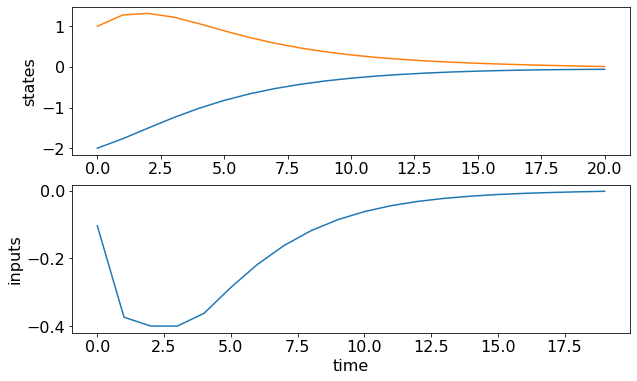

In [44]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

# plot the states
ax[0].plot(X_k.T)
ax[1].plot(U_k.T)

# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[1].set_xlabel('time')

## Task XX: Create and run MPC main loop
Now that everything is working, we can finally run the MPC loop.
At each iteration:

- pass the current initial state as a parameter
- run the solver
- extract the **current** control input from the optimal solution
- similarly to **Task XX:** Simulate the system (with the obtained control input) and obtain the next state
- store the current state and solution to ``res_x`` and ``res_u``
- reset the initial state to the next state

**NEVER** extract from the MPC results the next state of the system. **This is very important**. No matter how accurate your discretization scheme, you will always introduce an error. The real system development should always be obtained from a designated simulator, such as Sundials. The MPC results should only be considered a **prediction** of the future development of the system.

In [73]:
x_0 = np.array([-2,1]).reshape(2,1)
res_x_mpc = [x_0]
res_u_mpc = []

N_sim = 50

In [74]:
for i in range(N_sim):
    # solve optimization problem
    mpc_res = mpc_solver(p=x_0, lbg=0, ubg=0, lbx = lb_opt_x, ubx = ub_opt_x)
    if i>0:
        mpc_res = mpc_solver(p=x_0, x0=opt_x_k, lbg=0, ubg=0, lbx = lb_opt_x, ubx = ub_opt_x)
        
    
    # Extract the control input
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0]
    

    # simulate the system
    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']
    
    # Update the initial state
    x_0 = x_next
    
    # Store the results
    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)
    
# Make an array from the list of arrays:
res_x_mpc = np.concatenate(res_x_mpc,axis=1)
res_u_mpc = np.concatenate(res_u_mpc, axis=1)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      522
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      102

Total number of variables............................:      146
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      146
                     variables with only upper bounds:        0
Total number of equality constraints.................:      122
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   5  1.6815288e+00 1.11e-16 1.18e-14  -8.6 2.76e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.6815288124310563e+00    1.6815288124310563e+00
Dual infeasibility......:   1.1761326381905279e-14    1.1761326381905279e-14
Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
Complementarity.........:   2.5059167686060785e-09    2.5059167686060785e-09
Overall NLP error.......:   2.5059167686060785e-09    2.5059167686060785e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o fun

Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  10.00us (  1.67us)   9.00us (  1.50us)         6
       nlp_g  |  27.00us (  4.50us)  25.00us (  4.17us)         6
    nlp_grad  |  13.00us ( 13.00us)  12.00us ( 12.00us)         1
  nlp_grad_f  |  18.00us (  2.57us)  15.00us (  2.14us)         7
  nlp_hess_l  |  15.00us (  3.00us)  13.00us (  2.60us)         5
   nlp_jac_g  |  37.00us (  5.29us)  37.00us (  5.29us)         7
       total  |  33.44ms ( 33.44m

   1  4.3842418e-05 3.23e-12 5.22e-11  -1.0 1.33e-04    -  1.00e+00 1.00e+00h  1
   2  4.3842418e-05 4.34e-19 5.55e-17  -2.5 9.12e-09    -  1.00e+00 1.00e+00h  1
   3  4.3842418e-05 6.51e-19 6.03e-17  -3.8 6.43e-10    -  1.00e+00 1.00e+00h  1
   4  4.3842418e-05 4.34e-19 4.64e-17  -5.7 1.17e-11    -  1.00e+00 1.00e+00h  1
   5  4.3842418e-05 4.34e-19 3.48e-17  -8.6 1.35e-13    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   4.3842418216612964e-05    4.3842418216612964e-05
Dual infeasibility......:   3.4761014545454808e-17    3.4761014545454808e-17
Constraint violation....:   4.3368086899420177e-19    4.3368086899420177e-19
Complementarity.........:   2.5059035603029627e-09    2.5059035603029627e-09
Overall NLP error.......:   2.5059035603029627e-09    2.5059035603029627e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

Text(0.5, 0, 'time')

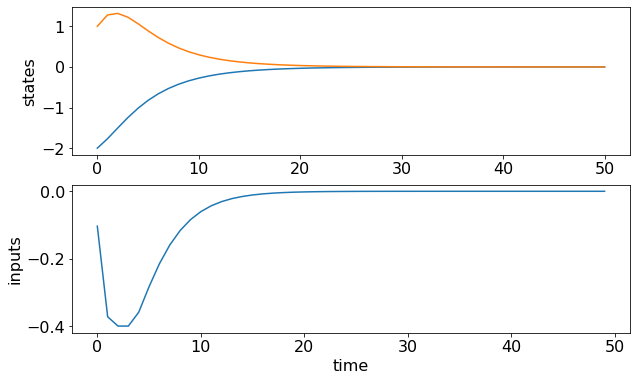

In [75]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

# plot the states
ax[0].plot(res_x_mpc.T)
ax[1].plot(res_u_mpc.T)

# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[1].set_xlabel('time')